In [1]:
# # ===================================================================
# # PART 1: PROJECT SETUP AND INSTALLATIONS
# # ===================================================================
# # Install all required packages
# !pip install -q pandas numpy torch torchvision opencv-python-headless scikit-learn matplotlib scikit-image tqdm ultralytics seaborn pyyaml

# # Import all libraries for the project
# import os
# import cv2
# import pandas as pd
# import numpy as np
# import yaml
# import shutil
# from skimage import measure
# from tqdm.notebook import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import warnings
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
# import torchvision.models as models
# from PIL import Image
# from ultralytics import YOLO
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Suppress minor warnings and set the primary device for computation
# warnings.filterwarnings("ignore", category=UserWarning)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"--- Setup Complete: Using device: {device} ---")


# # ===================================================================
# # PART 2: DATA PREP FOR THE HYBRID CNN MODEL
# # ===================================================================
# print("\n--- Starting Data Preparation for Hybrid CNN ---")
# # --- Helper functions ---
# def mask_to_bbox(mask):
#     contours = measure.find_contours(mask, 0.5)
#     if not contours: return None
#     points = np.concatenate(contours, axis=0)
#     y_min, x_min = points.min(axis=0)
#     y_max, x_max = points.max(axis=0)
#     return int(x_min), int(y_min), int(x_max), int(y_max)

# def get_peripapillary_bbox(disc_bbox, img_shape, scale_factor=2.5):
#     dx_min, dy_min, dx_max, dy_max = disc_bbox
#     img_h, img_w = img_shape[:2]
#     center_x, center_y = (dx_min + dx_max) / 2, (dy_min + dy_max) / 2
#     width, height = dx_max - dx_min, dy_max - dy_min
#     new_w, new_h = width * scale_factor, height * scale_factor
#     px_min = max(0, int(center_x - new_w / 2))
#     py_min = max(0, int(center_y - new_h / 2))
#     px_max = min(img_w - 1, int(center_x + new_w / 2))
#     py_max = min(img_h - 1, int(center_y + new_h / 2))
#     return px_min, py_min, px_max, py_max

# def process_dataset_for_hybrid(image_dir, mask_dir, dataset_name, labels_df=None):
#     data_list = []
#     for filename in tqdm(os.listdir(image_dir), desc=f"Processing {dataset_name} for Hybrid CNN"):
#         if not filename.lower().endswith(('.jpg', '.png', '.bmp')): continue
#         base_name, image_path = os.path.splitext(filename)[0], os.path.join(image_dir, filename)
#         # Handle different mask extensions
#         mask_path_png = os.path.join(mask_dir, f"{base_name}.png")
#         mask_path_bmp = os.path.join(mask_dir, f"{base_name}.bmp")
#         mask_path = mask_path_png if os.path.exists(mask_path_png) else mask_path_bmp
#         if not os.path.exists(mask_path): continue

#         if dataset_name == 'REFUGE':
#             label = 1 if base_name.lower().startswith(('g', 'ts')) else 0
#         elif labels_df is not None:
#             label_row = labels_df[labels_df['image_name'] == filename]
#             if label_row.empty: continue
#             label = label_row['label'].iloc[0]
#         else: continue

#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         if mask is None: continue
#         disc_bbox = mask_to_bbox(np.uint8(mask > 0))
#         if disc_bbox:
#             peri_bbox = get_peripapillary_bbox(disc_bbox, mask.shape)
#             data_list.append({'image_path': image_path, 'label': label, 'disc_x_min': disc_bbox[0], 'disc_y_min': disc_bbox[1], 'disc_x_max': disc_bbox[2], 'disc_y_max': disc_bbox[3], 'peri_x_min': peri_bbox[0], 'peri_y_min': peri_bbox[1], 'peri_x_max': peri_bbox[2], 'peri_y_max': peri_bbox[3], 'dataset': dataset_name})
#     return data_list

# # --- DEFINE YOUR KAGGLE DATASET PATHS HERE ---
# refuge_train_img_dir = '/kaggle/input/glaucoma-datasets/REFUGE/train/Images_Cropped'
# refuge_train_mask_dir = '/kaggle/input/glaucoma-datasets/REFUGE/train/Masks_Cropped'
# refuge_test_img_dir = '/kaggle/input/glaucoma-datasets/REFUGE/test/Images_Cropped'
# refuge_test_mask_dir = '/kaggle/input/glaucoma-datasets/REFUGE/test/Masks_Cropped'
# origa_img_dir = '/kaggle/input/glaucoma-datasets/ORIGA/Images'
# origa_mask_dir = '/kaggle/input/glaucoma-datasets/ORIGA/Masks'
# origa_labels_csv = '/kaggle/input/glaucoma-datasets/ORIGA/OrigaList.csv'
# # ---

# refuge_train_data = process_dataset_for_hybrid(refuge_train_img_dir, refuge_train_mask_dir, 'REFUGE')
# refuge_test_data = process_dataset_for_hybrid(refuge_test_img_dir, refuge_test_mask_dir, 'REFUGE')
# try:
#     origa_labels_df = pd.read_csv(origa_labels_csv).rename(columns={'Filename': 'image_name', 'Glaucoma': 'label'})
#     origa_data = process_dataset_for_hybrid(origa_img_dir, origa_mask_dir, 'ORIGA', labels_df=origa_labels_df)
# except FileNotFoundError: origa_data = []
# all_data = refuge_train_data + refuge_test_data + origa_data
# master_df = pd.DataFrame(all_data)
# master_df.to_csv('/kaggle/working/master_glaucoma_dataset.csv', index=False)
# print(f"\n--- Data Pre-processing for Hybrid CNN Complete ---")


# # ===================================================================
# # PART 3: DATA PREP & TRAINING FOR THE YOLOv8 MODEL
# # ===================================================================
# print("\n--- Starting YOLOv8 Data Preparation & Training ---")
# # Using REFUGE training set as it has the required masks
# REFUGE_IMG_DIR_YOLO = '/kaggle/input/glaucoma-datasets/REFUGE/train/Images_Cropped'
# REFUGE_MASK_DIR_YOLO = '/kaggle/input/glaucoma-datasets/REFUGE/train/Masks_Cropped'
# os.makedirs('yolo_dataset/images/train', exist_ok=True); os.makedirs('yolo_dataset/images/val', exist_ok=True)
# os.makedirs('yolo_dataset/labels/train', exist_ok=True); os.makedirs('yolo_dataset/labels/val', exist_ok=True)
# all_files = [f for f in os.listdir(REFUGE_IMG_DIR_YOLO) if f.lower().endswith('.jpg')]
# train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# def create_yolo_labels(filenames, img_dir, mask_dir, split):
#     for filename in tqdm(filenames, desc=f"Creating YOLO labels for {split}"):
#         base_name = os.path.splitext(filename)[0]
#         mask_path = os.path.join(mask_dir, f"{base_name}.png")
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         if mask is None: continue
#         h, w = mask.shape
#         disc_bbox = mask_to_bbox((mask > 0).astype(np.uint8))
#         cup_bbox = mask_to_bbox((mask > 128).astype(np.uint8))
#         with open(f'yolo_dataset/labels/{split}/{base_name}.txt', 'w') as f:
#             if disc_bbox:
#                 x_min, y_min, x_max, y_max = disc_bbox
#                 f.write(f"0 {(x_min + x_max)/(2*w)} {(y_min + y_max)/(2*h)} {(x_max - x_min)/w} {(y_max - y_min)/h}\n")
#             if cup_bbox:
#                 x_min, y_min, x_max, y_max = cup_bbox
#                 f.write(f"1 {(x_min + x_max)/(2*w)} {(y_min + y_max)/(2*h)} {(x_max - x_min)/w} {(y_max - y_min)/h}\n")
#         shutil.copy(os.path.join(img_dir, filename), f'yolo_dataset/images/{split}/{filename}')

# create_yolo_labels(train_files, REFUGE_IMG_DIR_YOLO, REFUGE_MASK_DIR_YOLO, 'train')
# create_yolo_labels(val_files, REFUGE_IMG_DIR_YOLO, REFUGE_MASK_DIR_YOLO, 'val')

# with open('data.yaml', 'w') as f:
#     yaml.dump({'train': '../yolo_dataset/images/train', 'val': '../yolo_dataset/images/val', 'nc': 2, 'names': ['optic_disc', 'optic_cup']}, f)

# model_yolo = YOLO('yolov8n.pt')
# model_yolo.train(data='data.yaml', epochs=50, imgsz=640, patience=10, name='yolo_glaucoma_det', exist_ok=True)
# YOLO_MODEL_PATH = 'runs/detect/yolo_glaucoma_det/weights/best.pt'
# print(f"--- YOLOv8 Training Complete. Best model saved to: {YOLO_MODEL_PATH} ---")


# # ===================================================================
# # PART 4: HYBRID MODEL ARCHITECTURE (WITH REAL VCDR)
# # ===================================================================
# # --- 1. Load the NEWLY TRAINED YOLOv8 Model ---
# yolo_model = YOLO(YOLO_MODEL_PATH)
# print(f"Successfully loaded newly trained YOLO model from: {YOLO_MODEL_PATH}")

# # --- 2. The REAL VCDR Calculation Function ---
# def get_vcdr_from_yolo(image_paths_batch):
#     vcdrs = []
#     try:
#         results_batch = yolo_model(image_paths_batch, verbose=False)
#     except Exception:
#         return torch.tensor([0.5] * len(image_paths_batch), dtype=torch.float32).to(device)
#     for results in results_batch:
#         boxes = results.boxes.xywh.cpu().numpy()
#         classes = results.boxes.cls.cpu().numpy()
#         disc_h, cup_h = None, None
#         for box, cls in zip(boxes, classes):
#             if cls == 0: disc_h = box[3]
#             elif cls == 1: cup_h = box[3]
#         if disc_h and cup_h and disc_h > 0: vcdrs.append(cup_h / disc_h)
#         else: vcdrs.append(0.5)
#     return torch.tensor(vcdrs, dtype=torch.float32).to(device)

# # --- 3. Custom Dataset, Models, and Transforms (definitions are unchanged) ---
# class GlaucomaDataset(Dataset):
#     def __init__(self, df, transforms=None): self.df, self.transforms = df, transforms
#     def __len__(self): return len(self.df)
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
#         disc = Image.fromarray(image[row['disc_y_min']:row['disc_y_max'], row['disc_x_min']:row['disc_x_max']])
#         peri = Image.fromarray(image[row['peri_y_min']:row['peri_y_max'], row['peri_x_min']:row['peri_x_max']])
#         if self.transforms: disc, peri = self.transforms(disc), self.transforms(peri)
#         return disc, peri, torch.tensor(row['label'], dtype=torch.float32), row['image_path']

# class SpecialistEnsemble(nn.Module):
#     def __init__(self):
#         super(SpecialistEnsemble, self).__init__()
#         self.disc_s = models.resnet18(weights=models.ResNet18_Weights.DEFAULT); self.disc_s.fc = nn.Linear(self.disc_s.fc.in_features, 256)
#         self.peri_s = models.resnet18(weights=models.ResNet18_Weights.DEFAULT); self.peri_s.fc = nn.Linear(self.peri_s.fc.in_features, 256)
#         self.attn = nn.Sequential(nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 512), nn.Sigmoid())
#     def forward(self, d_img, p_img):
#         d_feat, p_feat = self.disc_s(d_img), self.peri_s(p_img)
#         comb = torch.cat((d_feat, p_feat), dim=1)
#         return comb * self.attn(comb)

# class HybridGlaucomaModel(nn.Module):
#     def __init__(self, num_classes=1):
#         super(HybridGlaucomaModel, self).__init__()
#         self.cnn_parent = SpecialistEnsemble()
#         self.classifier = nn.Sequential(nn.Linear(512 + 1, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes))
#     def forward(self, d_img, p_img, vcdr):
#         img_feat = self.cnn_parent(d_img, p_img)
#         comb = torch.cat((img_feat, vcdr.unsqueeze(1)), dim=1)
#         return self.classifier(comb)

# IMG_SIZE = 224; mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# train_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(15), transforms.ColorJitter(brightness=0.2, contrast=0.2), transforms.ToTensor(), transforms.Normalize(mean, std)])
# val_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize(mean, std)])
# print("--- Model Architectures and Data Handlers Defined (with REAL VCDR calculation) ---")


# # ===================================================================
# # PART 5: THE COMPLETE HYBRID MODEL TRAINING SCRIPT (MULTI-GPU ENABLED)
# # ===================================================================
# master_df = pd.read_csv('/kaggle/working/master_glaucoma_dataset.csv')
# train_df, val_df = train_test_split(master_df, test_size=0.2, random_state=42, stratify=master_df['label'])

# train_dataset = GlaucomaDataset(df=train_df, transforms=train_transforms)
# val_dataset = GlaucomaDataset(df=val_df, transforms=val_transforms)
# train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)
# val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False, num_workers=2)
# print(f"\n--- Data Loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples ---")

# # --- Enable Multi-GPU if available ---
# model = HybridGlaucomaModel().to(device)
# if torch.cuda.device_count() > 1:
#     print(f"✅ Using {torch.cuda.device_count()} GPUs via DataParallel")
#     model = nn.DataParallel(model)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# NUM_EPOCHS = 25
# best_val_auc = 0.0
# history = {'train_loss': [], 'val_auc': []}

# print("\n--- Starting Hybrid Model Training (Multi-GPU Enabled) ---")
# for epoch in range(NUM_EPOCHS):
#     model.train()
#     running_loss = 0.0

#     for d_imgs, p_imgs, labels, paths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):
#         d_imgs, p_imgs, labels = d_imgs.to(device), p_imgs.to(device), labels.to(device).unsqueeze(1)
#         vcdrs = get_vcdr_from_yolo(paths)
#         outputs = model(d_imgs, p_imgs, vcdrs)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     history['train_loss'].append(running_loss / len(train_loader))

#     model.eval()
#     all_labels, all_scores = [], []
#     with torch.no_grad():
#         for d_imgs, p_imgs, labels, paths in val_loader:
#             d_imgs, p_imgs = d_imgs.to(device), p_imgs.to(device)
#             vcdrs = get_vcdr_from_yolo(paths)
#             scores = torch.sigmoid(model(d_imgs, p_imgs, vcdrs)).cpu().numpy().flatten()
#             all_labels.extend(labels.cpu().numpy())
#             all_scores.extend(scores)

#     epoch_val_auc = roc_auc_score(all_labels, all_scores)
#     history['val_auc'].append(epoch_val_auc)

#     print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {history['train_loss'][-1]:.4f} | Val AUC: {epoch_val_auc:.4f}")

#     if epoch_val_auc > best_val_auc:
#         best_val_auc = epoch_val_auc
#         torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
#                    'best_hybrid_model.pth')
#         print(f"✨ New best model saved with AUC: {best_val_auc:.4f}")

# print(f"\n--- Hybrid Model Training Complete --- Best Val AUC: {best_val_auc:.4f} ---")


# # ===================================================================
# # PART 6: FINAL REPORTING & SAVING RESULTS
# # ===================================================================
# RESULTS_DIR = 'project_results'; os.makedirs(RESULTS_DIR, exist_ok=True)
# print(f"\n--- Results will be saved in the '{RESULTS_DIR}' directory ---")
# model = HybridGlaucomaModel().to(device)
# model.load_state_dict(torch.load('best_hybrid_model.pth', map_location=device)); model.eval()
# all_labels, all_binary, all_scores = [], [], []
# with torch.no_grad():
#     for d_imgs, p_imgs, labels, paths in tqdm(val_loader, desc="Final Evaluation"):
#         d_imgs, p_imgs = d_imgs.to(device), p_imgs.to(device)
#         vcdrs = get_vcdr_from_yolo(paths)
#         scores = torch.sigmoid(model(d_imgs, p_imgs, vcdrs)).cpu().numpy().flatten()
#         all_labels.extend(labels.cpu().numpy().flatten())
#         all_scores.extend(scores)
#         all_binary.extend((scores > 0.5).astype(int))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# ax1.plot(history['train_loss'], label='Training Loss', color='orange'); ax1.set_title('Training Loss per Epoch'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True); ax1.legend()
# ax2.plot(history['val_auc'], label='Validation AUC', color='blue'); ax2.set_title('Validation AUC per Epoch'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC Score'); ax2.grid(True); ax2.legend()
# plt.savefig(os.path.join(RESULTS_DIR, 'training_performance.png'), dpi=300, bbox_inches='tight'); plt.show()
# report = classification_report(all_labels, all_binary, target_names=['Healthy (0)', 'Glaucoma (1)'])
# print("\n" + "="*50 + "\n      DETAILED CLASSIFICATION REPORT\n" + "="*50); print(report)
# fig, ax = plt.subplots(figsize=(8, 5)); ax.text(0.05, 0.95, report, va='top', fontfamily='monospace'); ax.axis('off'); plt.title('Classification Report')
# plt.savefig(os.path.join(RESULTS_DIR, 'classification_report.png'), dpi=300, bbox_inches='tight'); plt.close()
# cm = confusion_matrix(all_labels, all_binary)
# plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Healthy', 'Predicted Glaucoma'], yticklabels=['Actual Healthy', 'Actual Glaucoma'])
# plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.title('Confusion Matrix'); plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight'); plt.show()
# print("\n--- All results have been generated and saved! ---")

In [2]:
# ===================================================================
# PART 1: PROJECT SETUP AND INSTALLATIONS
# ===================================================================
!pip install -q pandas numpy torch torchvision opencv-python-headless scikit-learn matplotlib scikit-image tqdm ultralytics seaborn pyyaml

import os
import cv2
import pandas as pd
import numpy as np
import yaml
import shutil
from skimage import measure
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Setup Complete: Using device: {device} ---")


# ===================================================================
# PART 2: DATA PREP FOR THE HYBRID CNN MODEL
# ===================================================================
print("\n--- Starting Data Preparation for Hybrid CNN ---")

def mask_to_bbox(mask):
    contours = measure.find_contours(mask, 0.5)
    if not contours: return None
    points = np.concatenate(contours, axis=0)
    y_min, x_min = points.min(axis=0)
    y_max, x_max = points.max(axis=0)
    return int(x_min), int(y_min), int(x_max), int(y_max)

def get_peripapillary_bbox(disc_bbox, img_shape, scale_factor=2.5):
    dx_min, dy_min, dx_max, dy_max = disc_bbox
    img_h, img_w = img_shape[:2]
    center_x, center_y = (dx_min + dx_max) / 2, (dy_min + dy_max) / 2
    width, height = dx_max - dx_min, dy_max - dy_min
    new_w, new_h = width * scale_factor, height * scale_factor
    px_min = max(0, int(center_x - new_w / 2))
    py_min = max(0, int(center_y - new_h / 2))
    px_max = min(img_w - 1, int(center_x + new_w / 2))
    py_max = min(img_h - 1, int(center_y + new_h / 2))
    return px_min, py_min, px_max, py_max

def process_dataset_for_hybrid(image_dir, mask_dir, dataset_name, labels_df=None):
    data_list = []
    for filename in tqdm(os.listdir(image_dir), desc=f"Processing {dataset_name}"):
        if not filename.lower().endswith(('.jpg', '.png', '.bmp')): continue
        base_name, image_path = os.path.splitext(filename)[0], os.path.join(image_dir, filename)
        
        mask_path = os.path.join(mask_dir, f"{base_name}.png")
        if not os.path.exists(mask_path): mask_path = os.path.join(mask_dir, f"{base_name}.bmp")
        if not os.path.exists(mask_path): continue

        if dataset_name == 'REFUGE':
            label = 1 if base_name.lower().startswith(('g', 'ts')) else 0
        elif labels_df is not None:
            label_row = labels_df[labels_df['image_name'] == filename]
            if label_row.empty: continue
            label = label_row['label'].iloc[0]
        else: continue

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        # Disc = 1 or 2 (Everything not 0)
        disc_bbox = mask_to_bbox((mask > 0).astype(np.uint8))
        
        if disc_bbox:
            peri_bbox = get_peripapillary_bbox(disc_bbox, mask.shape)
            data_list.append({'image_path': image_path, 'label': label, 'disc_x_min': disc_bbox[0], 'disc_y_min': disc_bbox[1], 'disc_x_max': disc_bbox[2], 'disc_y_max': disc_bbox[3], 'peri_x_min': peri_bbox[0], 'peri_y_min': peri_bbox[1], 'peri_x_max': peri_bbox[2], 'peri_y_max': peri_bbox[3], 'dataset': dataset_name})
    return data_list

# PATHS
refuge_train_img = '/kaggle/input/glaucoma-datasets/REFUGE/train/Images_Cropped'
refuge_train_mask = '/kaggle/input/glaucoma-datasets/REFUGE/train/Masks_Cropped'
refuge_test_img = '/kaggle/input/glaucoma-datasets/REFUGE/test/Images_Cropped'
refuge_test_mask = '/kaggle/input/glaucoma-datasets/REFUGE/test/Masks_Cropped'
origa_img = '/kaggle/input/glaucoma-datasets/ORIGA/Images'
origa_mask = '/kaggle/input/glaucoma-datasets/ORIGA/Masks'
origa_labels = '/kaggle/input/glaucoma-datasets/ORIGA/OrigaList.csv'

# Execution
d1 = process_dataset_for_hybrid(refuge_train_img, refuge_train_mask, 'REFUGE')
d2 = process_dataset_for_hybrid(refuge_test_img, refuge_test_mask, 'REFUGE')
try:
    origa_df = pd.read_csv(origa_labels).rename(columns={'Filename': 'image_name', 'Glaucoma': 'label'})
    d3 = process_dataset_for_hybrid(origa_img, origa_mask, 'ORIGA', labels_df=origa_df)
except: d3 = []

master_df = pd.DataFrame(d1 + d2 + d3)
master_df.to_csv('/kaggle/working/master_glaucoma_dataset.csv', index=False)
print(f"--- Data Pre-processing Complete. Total Images: {len(master_df)} ---")


# ===================================================================
# PART 3: DATA PREP & TRAINING FOR THE YOLOv8 MODEL (FIXED FOR 0,1,2 MASKS)
# ===================================================================
print("\n--- Starting YOLOv8 Data Preparation & Training ---")
if os.path.exists('yolo_dataset'): shutil.rmtree('yolo_dataset')
os.makedirs('yolo_dataset/images/train', exist_ok=True); os.makedirs('yolo_dataset/images/val', exist_ok=True)
os.makedirs('yolo_dataset/labels/train', exist_ok=True); os.makedirs('yolo_dataset/labels/val', exist_ok=True)

all_files = [f for f in os.listdir(refuge_train_img) if f.lower().endswith('.jpg')]
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

def create_yolo_labels(filenames, img_dir, mask_dir, split):
    for filename in tqdm(filenames, desc=f"YOLO Labels {split}"):
        base_name = os.path.splitext(filename)[0]
        mask_path = os.path.join(mask_dir, f"{base_name}.png")
        if not os.path.exists(mask_path): mask_path = os.path.join(mask_dir, f"{base_name}.bmp")
        if not os.path.exists(mask_path): continue

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        h, w = mask.shape
        
        # --- FIXED LOGIC FOR 0,1,2 MASKS ---
        disc_bbox = mask_to_bbox((mask > 0).astype(np.uint8)) # 1+2
        cup_bbox = mask_to_bbox((mask == 2).astype(np.uint8)) # Only 2
        
        with open(f'yolo_dataset/labels/{split}/{base_name}.txt', 'w') as f:
            if disc_bbox:
                x_min, y_min, x_max, y_max = disc_bbox
                f.write(f"0 {(x_min + x_max)/(2*w)} {(y_min + y_max)/(2*h)} {(x_max - x_min)/w} {(y_max - y_min)/h}\n")
            if cup_bbox:
                x_min, y_min, x_max, y_max = cup_bbox
                f.write(f"1 {(x_min + x_max)/(2*w)} {(y_min + y_max)/(2*h)} {(x_max - x_min)/w} {(y_max - y_min)/h}\n")
        shutil.copy(os.path.join(img_dir, filename), f'yolo_dataset/images/{split}/{filename}')

create_yolo_labels(train_files, refuge_train_img, refuge_train_mask, 'train')
create_yolo_labels(val_files, refuge_train_img, refuge_train_mask, 'val')

with open('data.yaml', 'w') as f:
    yaml.dump({'train': '../yolo_dataset/images/train', 'val': '../yolo_dataset/images/val', 'nc': 2, 'names': ['optic_disc', 'optic_cup']}, f)

model_yolo = YOLO('yolov8n.pt')
model_yolo.train(data='data.yaml', epochs=30, imgsz=640, patience=5, name='yolo_glaucoma_det', exist_ok=True)
YOLO_MODEL_PATH = 'runs/detect/yolo_glaucoma_det/weights/best.pt'
print(f"--- YOLOv8 Training Complete. Saved to: {YOLO_MODEL_PATH} ---")


# ===================================================================
# PART 4: HYBRID MODEL ARCHITECTURE
# ===================================================================
yolo_model = YOLO(YOLO_MODEL_PATH)

def get_vcdr_from_yolo(image_paths_batch):
    vcdrs = []
    try:
        results_batch = yolo_model(image_paths_batch, verbose=False)
    except: return torch.tensor([0.5]*len(image_paths_batch), dtype=torch.float32).to(device)
    
    for results in results_batch:
        boxes = results.boxes.xywh.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy()
        disc_h, cup_h = None, None
        for box, cls in zip(boxes, classes):
            if cls == 0: disc_h = box[3]
            elif cls == 1: cup_h = box[3]
        if disc_h and cup_h and disc_h > 0: vcdrs.append(cup_h/disc_h)
        else: vcdrs.append(0.5)
    return torch.tensor(vcdrs, dtype=torch.float32).to(device)

class GlaucomaDataset(Dataset):
    def __init__(self, df, transforms=None): self.df, self.transforms = df, transforms
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
        disc = Image.fromarray(img[row['disc_y_min']:row['disc_y_max'], row['disc_x_min']:row['disc_x_max']])
        peri = Image.fromarray(img[row['peri_y_min']:row['peri_y_max'], row['peri_x_min']:row['peri_x_max']])
        if self.transforms: disc, peri = self.transforms(disc), self.transforms(peri)
        return disc, peri, torch.tensor(row['label'], dtype=torch.float32), row['image_path']

class SpecialistEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc_s = models.resnet18(weights='DEFAULT'); self.disc_s.fc = nn.Linear(512, 256)
        self.peri_s = models.resnet18(weights='DEFAULT'); self.peri_s.fc = nn.Linear(512, 256)
        self.attn = nn.Sequential(nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 512), nn.Sigmoid())
    def forward(self, d, p):
        comb = torch.cat((self.disc_s(d), self.peri_s(p)), dim=1)
        return comb * self.attn(comb)

class HybridGlaucomaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_parent = SpecialistEnsemble()
        self.classifier = nn.Sequential(nn.Linear(513, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 1))
    def forward(self, d, p, v):
        return self.classifier(torch.cat((self.cnn_parent(d, p), v.unsqueeze(1)), dim=1))

IMG_SIZE = 224; mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_aug = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(20), transforms.ColorJitter(0.2,0.2), transforms.ToTensor(), transforms.Normalize(mean, std)])
val_aug = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize(mean, std)])


# ===================================================================
# PART 5: HYBRID TRAINING WITH **WEIGHTED SAMPLER** (THE FIX)
# ===================================================================
print("\n--- Starting Hybrid Model Training with Balancing ---")
master_df = pd.read_csv('/kaggle/working/master_glaucoma_dataset.csv')
train_df, val_df = train_test_split(master_df, test_size=0.2, random_state=42, stratify=master_df['label'])

train_dataset = GlaucomaDataset(train_df, train_aug)
val_dataset = GlaucomaDataset(val_df, val_aug)

# --- CALCULATE WEIGHTS TO FIX IMBALANCE ---
class_counts = train_df['label'].value_counts().sort_index()
class_weights = 1. / class_counts
sample_weights = train_df['label'].map(class_weights).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
# -------------------------------------------

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2) # shuffle=False with sampler!
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

model = HybridGlaucomaModel()
if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
history = {'train_loss': [], 'val_auc': []}
best_auc = 0.0

for epoch in range(25):
    model.train(); run_loss = 0.0
    for d, p, l, paths in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        d, p, l = d.to(device), p.to(device), l.to(device).unsqueeze(1)
        v = get_vcdr_from_yolo(paths)
        optimizer.zero_grad()
        loss = criterion(model(d, p, v), l)
        loss.backward(); optimizer.step()
        run_loss += loss.item()
    
    model.eval(); preds, targets = [], []
    with torch.no_grad():
        for d, p, l, paths in val_loader:
            d, p = d.to(device), p.to(device)
            v = get_vcdr_from_yolo(paths)
            preds.extend(torch.sigmoid(model(d, p, v)).cpu().numpy().flatten())
            targets.extend(l.numpy())
            
    auc = roc_auc_score(targets, preds)
    history['val_auc'].append(auc)
    history['train_loss'].append(run_loss/len(train_loader))
    print(f"Epoch {epoch+1} | Loss: {run_loss/len(train_loader):.4f} | Val AUC: {auc:.4f}")
    
    if auc > best_auc:
        best_auc = auc
        torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), 'best_hybrid_model.pth')
        print(f"✨ Saved Best Model (AUC: {best_auc:.4f})")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytic

Processing REFUGE:   0%|          | 0/400 [00:00<?, ?it/s]

Processing REFUGE:   0%|          | 0/400 [00:00<?, ?it/s]

Processing ORIGA:   0%|          | 0/650 [00:00<?, ?it/s]

--- Data Pre-processing Complete. Total Images: 1450 ---

--- Starting YOLOv8 Data Preparation & Training ---


YOLO Labels train:   0%|          | 0/320 [00:00<?, ?it/s]

YOLO Labels val:   0%|          | 0/80 [00:00<?, ?it/s]

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_glaucoma_det, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretr

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         80        160      0.988      0.975      0.988      0.733
            optic_disc         80         80       0.99          1      0.995      0.901
             optic_cup         80         80      0.986       0.95      0.981      0.565
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/yolo_glaucoma_det
--- YOLOv8 Training Complete. Saved to: runs/detect/yolo_glaucoma_det/weights/best.pt ---

--- Starting Hybrid Model Training with Balancing ---


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1 | Loss: 0.5385 | Val AUC: 0.8911
✨ Saved Best Model (AUC: 0.8911)


Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.3566 | Val AUC: 0.8469


Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.2920 | Val AUC: 0.9120
✨ Saved Best Model (AUC: 0.9120)


Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.2432 | Val AUC: 0.9209
✨ Saved Best Model (AUC: 0.9209)


Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.1690 | Val AUC: 0.9216
✨ Saved Best Model (AUC: 0.9216)


Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.1997 | Val AUC: 0.9020


Epoch 7:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.1649 | Val AUC: 0.9198


Epoch 8:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.1033 | Val AUC: 0.9169


Epoch 9:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.1227 | Val AUC: 0.9009


Epoch 10:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.1199 | Val AUC: 0.8909


Epoch 11:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.1360 | Val AUC: 0.9210


Epoch 12:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.0794 | Val AUC: 0.8881


Epoch 13:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.1060 | Val AUC: 0.9251
✨ Saved Best Model (AUC: 0.9251)


Epoch 14:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.1006 | Val AUC: 0.8924


Epoch 15:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.0841 | Val AUC: 0.9055


Epoch 16:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.0586 | Val AUC: 0.9256
✨ Saved Best Model (AUC: 0.9256)


Epoch 17:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.0459 | Val AUC: 0.8947


Epoch 18:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.0680 | Val AUC: 0.8865


Epoch 19:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.1662 | Val AUC: 0.8973


Epoch 20:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.0745 | Val AUC: 0.9237


Epoch 21:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.0696 | Val AUC: 0.9136


Epoch 22:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.1548 | Val AUC: 0.9324
✨ Saved Best Model (AUC: 0.9324)


Epoch 23:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.0821 | Val AUC: 0.9219


Epoch 24:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.0528 | Val AUC: 0.8963


Epoch 25:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.0476 | Val AUC: 0.8987



--- Results will be saved in the 'project_results' directory ---
Base model weights loaded successfully.
Using 2 GPUs for evaluation.


Final Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

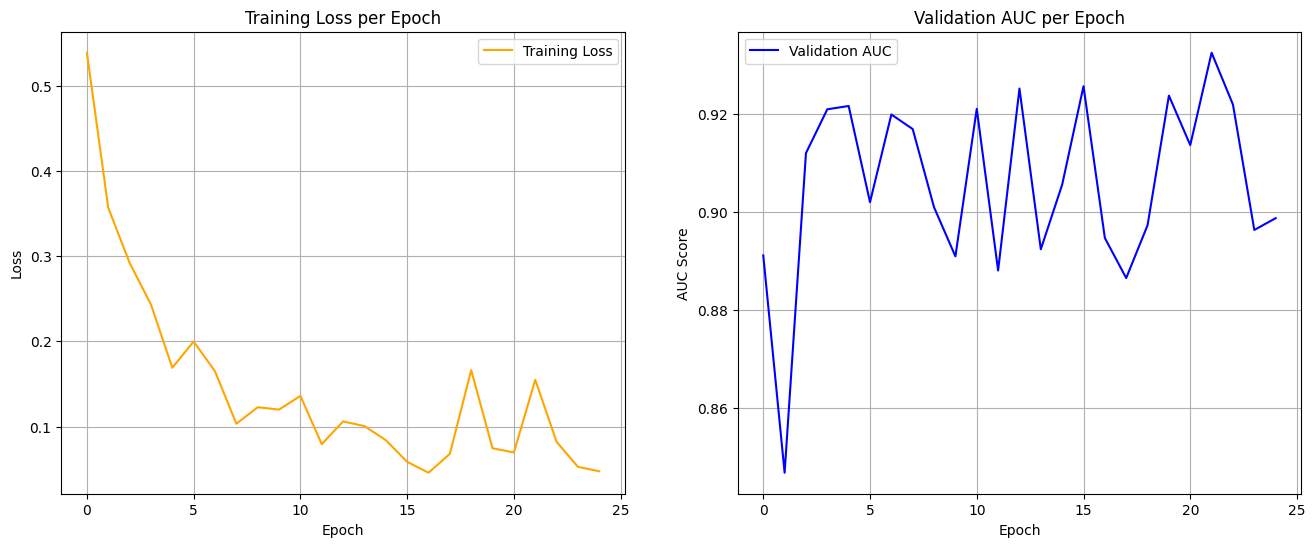


      DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Healthy (0)       0.92      0.95      0.94       248
Glaucoma (1)       0.65      0.52      0.58        42

    accuracy                           0.89       290
   macro avg       0.78      0.74      0.76       290
weighted avg       0.88      0.89      0.88       290



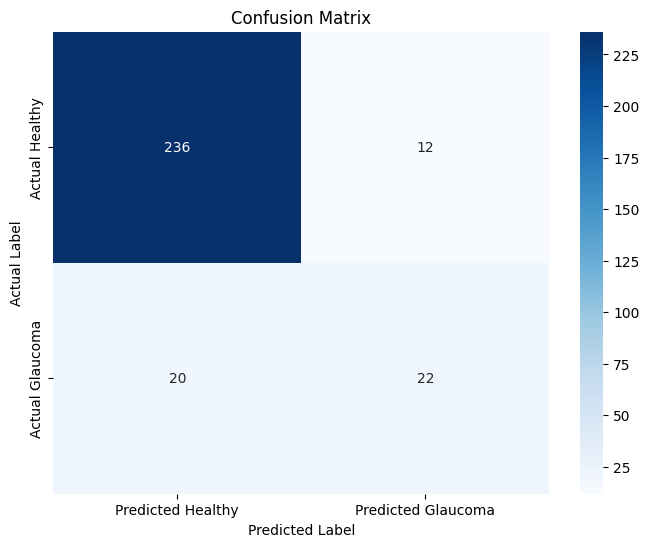


--- All results have been generated and saved! ---


In [3]:
# ===================================================================
# PART 6: FINAL REPORTING & SAVING RESULTS (CORRECTED LOADING)
# ===================================================================
RESULTS_DIR = 'project_results'; os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"\n--- Results will be saved in the '{RESULTS_DIR}' directory ---")

# 1. Instantiate the base model
model = HybridGlaucomaModel()

# 2. Load the weights *BEFORE* wrapping in DataParallel
# This matches the keys in the saved file exactly
MODEL_SAVE_PATH = 'best_hybrid_model.pth'
try:
    state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
    model.load_state_dict(state_dict)
    print("Base model weights loaded successfully.")
except RuntimeError as e:
    # Fallback: If for some reason weights were saved WITH 'module.', handle it
    print("Trying to load with 'module.' prefix fix...")
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

# 3. NOW wrap in DataParallel and move to device
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for evaluation.")
    model = nn.DataParallel(model)

model = model.to(device)
model.eval()

# 4. Evaluation Loop
all_labels, all_binary, all_scores = [], [], []
with torch.no_grad():
    for d_imgs, p_imgs, labels, paths in tqdm(val_loader, desc="Final Evaluation"):
        d_imgs, p_imgs = d_imgs.to(device), p_imgs.to(device)
        vcdrs = get_vcdr_from_yolo(paths)
        scores = torch.sigmoid(model(d_imgs, p_imgs, vcdrs)).cpu().numpy().flatten()
        all_labels.extend(labels.cpu().numpy().flatten())
        all_scores.extend(scores)
        # Using default 0.5 threshold for initial report
        all_binary.extend((scores > 0.5).astype(int))

# 5. Generate Plots & Reports
# A) Training History
if len(history['train_loss']) > 0: # Check if history exists
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(history['train_loss'], label='Training Loss', color='orange')
    ax1.set_title('Training Loss per Epoch'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True); ax1.legend()
    ax2.plot(history['val_auc'], label='Validation AUC', color='blue')
    ax2.set_title('Validation AUC per Epoch'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC Score'); ax2.grid(True); ax2.legend()
    plt.savefig(os.path.join(RESULTS_DIR, 'training_performance.png'), dpi=300, bbox_inches='tight'); plt.show()

# B) Classification Report
report = classification_report(all_labels, all_binary, target_names=['Healthy (0)', 'Glaucoma (1)'])
print("\n" + "="*50 + "\n      DETAILED CLASSIFICATION REPORT\n" + "="*50); print(report)
fig, ax = plt.subplots(figsize=(8, 5)); ax.text(0.05, 0.95, report, va='top', fontfamily='monospace'); ax.axis('off'); plt.title('Classification Report')
plt.savefig(os.path.join(RESULTS_DIR, 'classification_report.png'), dpi=300, bbox_inches='tight'); plt.close()

# C) Confusion Matrix
cm = confusion_matrix(all_labels, all_binary)
plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Healthy', 'Predicted Glaucoma'], yticklabels=['Actual Healthy', 'Actual Glaucoma'])
plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.title('Confusion Matrix'); plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight'); plt.show()

print("\n--- All results have been generated and saved! ---")